In [1]:
!pip install joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings('ignore')

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
data_version = "Trained_V2-3.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

Mounted at /content/drive


In [3]:
import joblib

In [4]:

df_raw = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  df_raw = df_raw.set_index('SEQN', drop=True)
  df_raw = df_raw.drop(columns = "Unnamed: 0")
except:
  pass

df_raw.head()

,Dieta1_DRDINT,Dieta1_DR1TFIBE,Quest21_SLQ300,Quest19_PAD660,Quest19_PAQ635,Dieta1_DR1TCHOL,Quest19_PAQ655,Dieta1_DR1TSFAT,Dieta1_DR1TKCAL,Exami2_BMXBMI,...,Quest1_ALQ111,Quest10_ECQ020,Quest16_MCQ220,Quest4_CBD121,Quest16_MCQ366A,Labor2_URDFLOW1,Demog1_DMDEDUC,Quest9_DLQ050,Quest20_PFQ061C,Quest16_MCQ160B
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,1,0,2,2,2.0,0,2,1,0,2,...,1.0,9.0,2.0,7.500000e+01,2.0,1.204,2.0,2.0,1.0,2.0
93708.0,1,2,2,2,2.0,0,2,1,0,0,...,2.0,9.0,2.0,5.397605e-79,2.0,0.500,1.0,2.0,2.0,2.0
93709.0,0,2,2,1,2.0,2,1,2,1,3,...,9.0,9.0,2.0,4.000000e+01,2.0,0.107,4.0,1.0,9.0,2.0
93711.0,1,3,1,0,1.0,3,3,3,3,0,...,1.0,9.0,2.0,8.570000e+02,2.0,0.605,5.0,2.0,9.0,2.0
93713.0,1,1,2,1,1.0,1,2,3,2,0,...,1.0,9.0,2.0,4.000000e+01,2.0,0.706,3.0,2.0,1.0,2.0


In [5]:
def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical


In [6]:
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def prep_data_cross_validation(df, num_folds=5):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  kf = KFold(n_splits=num_folds, shuffle=True, random_state=37)

  for train_index, val_index in kf.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_index, :], X.iloc[val_index, :], y.iloc[train_index], y.iloc[val_index]

    # Instantiate the SMOTE oversampler
    smotenc = SMOTENC(
        categorical_features=categorical_cols,
        sampling_strategy='auto',
        random_state=37
      )

    # Apply SMOTE to generate synthetic samples
    X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_resampled.iloc[:, 28:] = scaler.fit_transform(X_resampled.iloc[:, 28:])
    X_val.iloc[:, 28:] = scaler.transform(X_val.iloc[:, 28:])

    X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
    X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

    yield X_resampled, X_val, y_resampled, y_val


In [7]:
def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC, SMOTE

def prep_data_final(df):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  # Instantiate the SMOTE oversampler
  smotenc = SMOTENC(
      categorical_features=categorical_cols,
      sampling_strategy='auto',
      random_state=37
    )

  smote = SMOTE(random_state=37)

  # Apply SMOTE to generate synthetic samples
  X_resampled, y_resampled = smote.fit_resample(X, y)

  scaler = StandardScaler()
  X_resampled.iloc[:, 28:] = scaler.fit_transform(X_resampled.iloc[:, 28:])

  X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)

  return X_resampled,y_resampled

X, y = prep_data_final(df_raw)
input_shape = X.shape[1:]

print(y.value_counts())

Quest16_MCQ160B
0    5368
1    5368
Name: count, dtype: int64


In [9]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=()):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.logs = {}

    def on_epoch_end(self, epoch, logs={}):
        if not self.validation_data:
            raise RuntimeError("Requires validation_data.")
        if self.logs.get('roc_auc', None) == None:
          self.logs['roc_auc'] = []
        if self.logs.get('f1score', None) == None:
          self.logs['f1score'] = []

        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)

        # Convert one-hot encoded labels to class labels
        y_pred =  [1 if preds[1] >= 2.46069816967065e-06 else 0 for preds in y_pred]

        # Compute Metrics score
        f1score = f1_score(y_val, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

        # Add Metrics score to logs
        self.logs['roc_auc'].append(roc_auc)
        self.logs['f1score'].append(f1score)

In [10]:

def build_model():
  model = models.Sequential()
  model.add(layers.Input(input_shape))
  model.add(layers.Conv1D(filters=4, kernel_size=3, activation='relu'))
  model.add(layers.Conv1D(filters=32, kernel_size=2, activation='relu'))
  model.add(layers.Conv1D(filters=8, kernel_size=2, activation='relu'))
  model.add(layers.Conv1D(filters=8, kernel_size=3, activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(units=8, activation='relu'))
  model.add(layers.Dense(units=8, activation='relu'))
  model.add(layers.Dense(units=4, activation='relu'))
  model.add(layers.Dense(units=16, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [11]:
tf.random.set_seed(37)
random.seed(37)

loss = []
accuracy = []
f1score = []
auc = []

X, y = prep_data_final(df_raw)

model = build_model()
metrics_callback = MetricsCallback(validation_data=(X, y))

history = model.fit(X, y, epochs=20, callbacks=[metrics_callback])

_loss, _accuracy = model.evaluate(X, y, verbose=0)
loss.append(_loss)
accuracy.append(_accuracy)
f1score.append(metrics_callback.logs.get('f1score'))
auc.append(metrics_callback.logs.get('roc_auc'))

print()
model.summary()

Epoch 1/20
336/336 [==============================] - 12s 20ms/step - loss: 0.3519 - accuracy: 0.8359
Epoch 2/20
336/336 [==============================] - 8s 24ms/step - loss: 0.1972 - accuracy: 0.9262
Epoch 3/20
336/336 [==============================] - 6s 19ms/step - loss: 0.1565 - accuracy: 0.9402
Epoch 4/20
336/336 [==============================] - 6s 17ms/step - loss: 0.1300 - accuracy: 0.9508
Epoch 5/20
336/336 [==============================] - 8s 23ms/step - loss: 0.1262 - accuracy: 0.9528
Epoch 6/20
336/336 [==============================] - 3s 8ms/step - loss: 0.1132 - accuracy: 0.9578
Epoch 7/20
336/336 [==============================] - 3s 10ms/step - loss: 0.1119 - accuracy: 0.9586
Epoch 8/20
336/336 [==============================] - 4s 10ms/step - loss: 0.0997 - accuracy: 0.9633
Epoch 9/20
336/336 [==============================] - 3s 10ms/step - loss: 0.0933 - accuracy: 0.9662
Epoch 10/20
336/336 [==============================] - 3s 10ms/step - loss: 0.0836 - accura

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Evaluate Model

proba = model.predict(X)
preds = np.argmax(proba, axis=1)

print("Accuracy: " + str(accuracy_score(y, preds)*100) + "%")
print("F1 Score: " + str(f1_score(y, preds, average='micro')*100) + "%")
print("AUC: " + str(roc_auc_score(y, preds, average='micro')*100) + "%")

print(confusion_matrix(y, preds))

336/336 [==============================] - 1s 2ms/step
Accuracy: 98.20230998509687%
F1 Score: 98.20230998509687%
AUC: 98.20230998509687%
[[5231  137]
 [  56 5312]]


In [13]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, model.predict(X)[:, 1])

# Compute the optimal threshold by maximizing the Youden's J statistic
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

# Alternatively, you can minimize the distance to the top-left corner (0,1)
distances = np.sqrt(fpr**2 + (1-tpr)**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")

336/336 [==============================] - 1s 2ms/step
Optimal threshold: 0.7240983843803406


In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Evaluate Model

proba = model.predict(X)
preds = [1 if prob >= 0.12201773375272751 else 0 for prob in proba[:, 1]]

print("Accuracy: " + str(accuracy_score(y, preds)*100) + "%")
print("F1 Score: " + str(f1_score(y, preds, average='micro')*100) + "%")
print("AUC: " + str(roc_auc_score(y, preds, average='micro')*100) + "%")

print(confusion_matrix(y, preds))

336/336 [==============================] - 1s 3ms/step
Accuracy: 96.43256333830105%
F1 Score: 96.43256333830105%
AUC: 96.43256333830105%
[[4998  370]
 [  13 5355]]


# Summarize Model

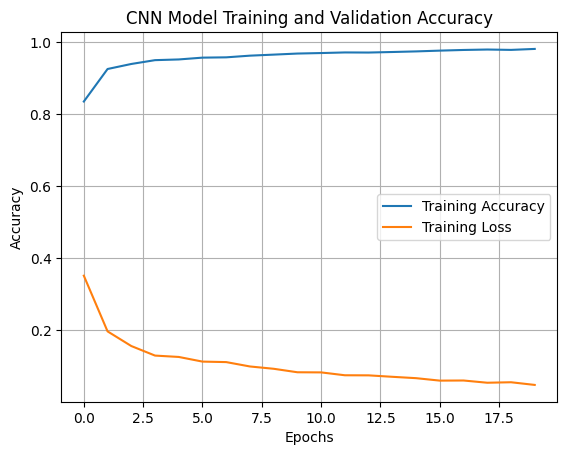

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()